In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Models
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingClassifier

# Processing and metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import itertools

# Optimization
from scipy.stats import uniform, loguniform
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval
from hyperopt.pyll import scope

# NLP
import gensim
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import re

In [33]:
data = pd.read_csv("./data/competition_data.csv")

## Analisis de datos

La siguiente celda la usamos para ver las distribuciones de probabilidad de conversion para cada atributo.

In [ ]:
# plt.figure(figsize=(5, 5))
# for col in data.columns:
#     mean_conv = data.groupby(col)['conversion'].mean()
#     sns.histplot(data=mean_conv, x=mean_conv.index, weights=mean_conv.values, color='red', stat='probability', bins=10)
#     plt.show()

En el siguiente gráfico podemos ver que mientras más arriba se encuentre en la página el anuncio mayor probabilidad de conversión. 

<Axes: xlabel='print_position', ylabel='Probability'>

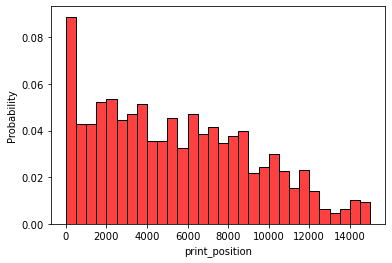

In [40]:
mean_conv = data.groupby('print_position')['conversion'].mean()
sns.histplot(data=mean_conv, x=mean_conv.index, weights=mean_conv.values, color='red', stat='probability', bins=30)

Efecto de escalado en las variables asimétricas. Ocurre con muchas de ellas, en particular las relacionadas al precio y cantidades del producto.

Text(0.5, 1.0, 'Price distribution after scaling')

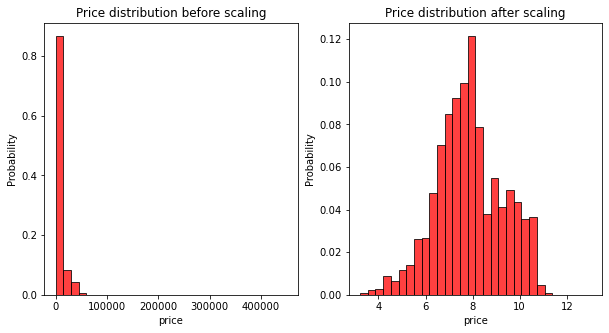

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

mean_conv = data.groupby('price')['conversion'].mean()
sns.histplot(data=mean_conv, x=mean_conv.index, weights=mean_conv.values, color='red', stat='probability', bins=30, ax=ax1)
ax1.set_title('Price distribution before scaling')
data['price'] = np.log1p(data['price'])
mean_conv = data.groupby('price')['conversion'].mean()
sns.histplot(data=mean_conv, x=mean_conv.index, weights=mean_conv.values, color='red', stat='probability', bins=30, ax=ax2)
ax2.set_title('Price distribution after scaling')

Plot de distribución de probabilidades para atributos que supusimos relevantes

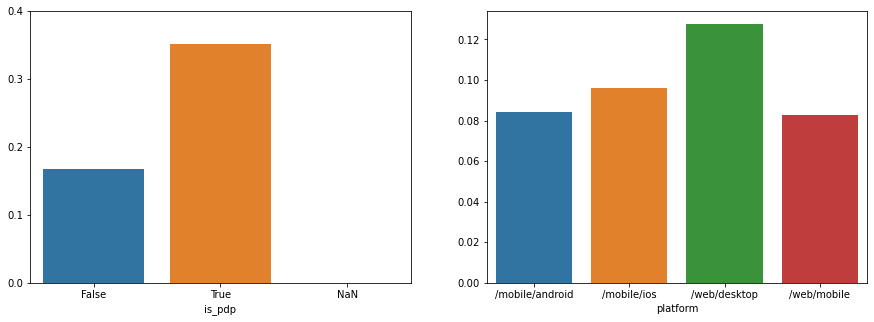

In [21]:
fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

data['is_pdp'].fillna(2, inplace=True)
mean_conversion = data.groupby('is_pdp')['conversion'].mean()
mean_conversion.index = mean_conversion.index.astype(str)
sns.barplot(x=mean_conversion.index, y=mean_conversion.values, ax=ax1)
ax1.set_xticks([0, 1, 2], ['False', 'True', 'NaN'], rotation=0)
ax1.set_yticks(np.arange(0, 0.41, 0.1))

mean_conversion = data.groupby('platform')['conversion'].mean()
mean_conversion.index = mean_conversion.index.astype(str)
sns.barplot(x=mean_conversion.index, y=mean_conversion.values, ax=ax2)

plt.show()

In [23]:
data = pd.read_csv("./data/competition_data.csv")

199972 199972


# Procesamiento de datos

#### Filtering e ingenieria de atributos
Se realiza una selección de variables por filtering. Luego se realizan las conversiones de datos necesarias.

In [24]:
data.drop(columns=['benefit', 'deal_print_id','etl_version', 'accepts_mercadopago', 
                   'item_id', 'main_picture', 'date', 'boosted',
                   'site_id','uid', 'user_id', 'domain_id'], axis= "columns", inplace=True)

# Y casting to bool
data['conversion'] = data['conversion'].astype('bool')

Extraemos la cantidad de dias de *warranty* y reemplazamos columna con esos valores

In [25]:
def extract_warr_days(text):
    if len(text) > 80:
        return 0
    matchD = re.search(r'(\d+)\s+d(i|í)as', text)
    matchM = re.search(r'(\d+)\s+m(e|é)ses', text)
    matchY = re.search(r'(\d+)\s+a(n|ñ)os', text)
    if matchD:
        return int(matchD.group(1))
    elif matchM:
        return int(matchM.group(1))*30
    elif matchY:
        return int(matchY.group(1))*365
    else:
        return None
    
data['warranty'] = data['warranty'].fillna("Sin garantia").apply(lambda x: extract_warr_days(x)).fillna(0)

Separamos la fecha en diferente columnas.

In [26]:
data["print_server_timestamp"] = pd.to_datetime(data["print_server_timestamp"])
data["hour"] = data["print_server_timestamp"].dt.hour
data["day"] = data["print_server_timestamp"].dt.day
data["month"] = data["print_server_timestamp"].dt.month
data["day_of_week"] = data["print_server_timestamp"].dt.dayofweek
data['week_of_month'] = data['print_server_timestamp'].apply(lambda d: (d.day-1) // 7 + 1)
data.drop(columns=["print_server_timestamp"], axis= "columns", inplace=True)

Transformamos las variables categoricas con OHE.

In [27]:
data = pd.get_dummies(data, columns = ["platform", "logistic_type"], dummy_na = False, dtype = int)
data["listing_type_id"] = data["listing_type_id"].apply(lambda x: 1 if x == 'gold_pro' else (2 if x == 'gold_special' else x))
data["is_pdp"] = pd.to_numeric(data["is_pdp"], errors="coerce")

La columna tags posee una lista de tags. Creamos una columna para cada uno de los 18 tags que existen, y codificamos segun los tags presentes en cada observacion

In [28]:
data['tags'] = data['tags'].str.strip('][').str.split(', ')
tags = set()
for i in data['tags']:
    for tag in i:
        tags.add("tag_" + tag)
tags = list(tags)

for tag in tags:
    data[tag] = data['tags'].apply(lambda x: 1 if tag in x else 0)

data = data.drop(columns=['tags'], axis= "columns")

La columna full_name posee una cadena de la categoria y subcategorias en las que se encuentra el producto. Extramos la primera de las categorias (mas amplia) y hacemos OHE.

In [29]:
def extract_first_name(x):
    names = x.split("->")
    if len(names) > 1:
        return names[0][:-1]
    else:
        return None

data['category_name'] = data['full_name'].apply(lambda x: extract_first_name(x))
data = data.drop(columns=['full_name'], axis= "columns")
data = pd.get_dummies(data, columns = ["category_name"])

Creamos dos columnas nuevas: una para el descuento en total y otra para el descuento en porcentaje del precio original.

In [30]:
data['discount'] = data['original_price'] - data['price']
data['discount_perc'] = data['discount'] / data['original_price']
data['market_share'] = data['total_si_sel_30days'] / data['total_si_domain_30days']

In [31]:
top_categories = data["category_id"].value_counts().nlargest(10).index
top_product_ids = data["product_id"].value_counts().nlargest(10).index

for category in top_categories:
    data[f"category{category}"] = (data["category_id"] == category).astype(int)

for product_id in top_product_ids:
    data[f"product{product_id}"] = (data["product_id"] == product_id).astype(int)
    
data.drop(columns=["category_id", "product_id"], inplace=True)

In [32]:
columns_to_scale = [
    "available_quantity", 
    'avg_gmv_item_domain_30days', 
    'avg_gmv_item_sel', 
    'avg_gmv_seller_bday', 
    'avg_qty_orders_item_domain_30days',
    'avg_qty_orders_item_sel_30days',
    'avg_si_item_sel_30day',
    'health',
    'offset',
    'original_price',
    'price',
    'print_position',
    'qty_items_dom',
    'qty_items_sel',
    'sold_quantity',
    'total_asp_item_domain_30days',
    'total_asp_item_sel_30days',
    'total_gmv_domain_bday',
    'total_gmv_item_30days',
    'total_items_domain',
    'total_items_seller',
    'total_orders_domain_30days',
    'total_orders_item_30days',
    'total_orders_sel_30days',
    'total_si_domain_30days',
    'total_si_item_30days',
    'total_si_sel_30days',
    'total_visits_domain',
    'total_visits_item',
    'total_visits_seller'
    ]
data[columns_to_scale] = np.log1p(data[columns_to_scale])

In [33]:
columns_to_cross = ["print_position", "offset", "discount", "price", "health", "original_price"]

feature_cross = PolynomialFeatures(2)
feature_cross.fit(SimpleImputer(strategy='mean').fit_transform(data[columns_to_cross]))
crossed_features = feature_cross.transform(SimpleImputer(strategy='mean').fit_transform(data[columns_to_cross]))
crossed_features = pd.DataFrame(crossed_features, columns=feature_cross.get_feature_names_out(columns_to_cross))
data = data.join(crossed_features.drop(columns=columns_to_cross, axis= "columns"))

#### Procesamiento de columna 'title' con w2v

In [34]:
def tokenizer(raw_text):
    """
    Tokeniza y preprocesa un texto.

    Args:
        raw_text (str): Texto sin procesar.

    Returns:
        list: Lista de oraciones, donde cada oración es una lista de palabras.
    """
    sentences = sent_tokenize(raw_text)
    sentences = [word_tokenize(e) for e in sentences]
    sentences = [[e2 for e2 in e1 if re.compile("[A-Za-z]").search(e2[0])] for e1 in sentences]
    sentences = [[e2.lower() for e2 in e1] for e1 in sentences]
    return(sentences)

def average_vectors(title_tokens, model, stopwords=None):
    """
    Calcula el vector promedio de un conjunto de tokens utilizando un modelo Word2Vec.

    Args:
        title_tokens (list): Lista de tokens.
        model (gensim.models.Word2Vec): Modelo Word2Vec.
        stopwords (set, optional): Conjunto de palabras stopwords. Defaults to None.

    Returns:
        numpy.ndarray: Vector promedio.
    """
    title_tokens = [e2 for e1 in title_tokens for e2 in e1]
    title_tokens = [e for e in title_tokens if e in model.wv]
    if stopwords is not None:
        title_tokens = [e for e in title_tokens if e not in stopwords]
    if len(title_tokens) == 0:
        output = np.zeros(model.wv.vector_size)
    else:
        output = np.array([model.wv.get_vector(e) for e in title_tokens]).mean(0)
    return output

In [35]:
STOP_WORDS_SP = set(stopwords.words('spanish'))
data["title_tokens"] = data["title"].map(tokenizer)

# Creación del modelo Word2Vec
w2v_tp = gensim.models.Word2Vec(vector_size=30,
                                window=3,
                                min_count=5,
                                negative=10,
                                sample=0.01,
                                workers=8,
                                sg=1)

# Creación del vocabulario a partir del corpus
w2v_tp.build_vocab([e2 for e1 in data["title_tokens"].values for e2 in e1],
                   progress_per=10000)

# Entrenamiento del modelo Word2Vec
w2v_tp.train([e2 for e1 in data["title_tokens"].values for e2 in e1],
             total_examples=w2v_tp.corpus_count,
             epochs=50, report_delay=1)

(74029775, 74992250)

In [36]:
title_embs = data["title_tokens"].map(lambda x: average_vectors(x, w2v_tp, STOP_WORDS_SP))
title_embs = np.array(title_embs.to_list())
data = pd.concat([data, pd.DataFrame(title_embs, columns=[f'emb_{i}' for i in range(30)])], axis=1)

In [37]:
data.drop(columns=["title", "title_tokens"], axis= "columns", inplace=True)

In [38]:
data.to_csv("./data/competition_data_ready.csv", index=False)

# Entrenamiento del modelo

Separamos el dataset en conjunto de Train y Test. Dentro del conjunto de Train dividimos un holdout set para validación con el 20% de las observaciones.

In [2]:
data = pd.read_csv("./data/competition_data_ready.csv")

train_data = data[data["ROW_ID"].isna()]
test_data = data[data["ROW_ID"].notna()]

train_data.columns = train_data.columns.astype(str)
test_data.columns = test_data.columns.astype(str)

x_train = train_data.drop(columns=["conversion", "ROW_ID"])
y_train = train_data["conversion"]

X_test = test_data.drop(columns=["conversion", "ROW_ID"])
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=3456)

Se crea un conjunto más pequeño para hacer optimización de hiperparametros

In [ ]:
space2 = {
        "n_estimators": scope.int(hp.uniform("n_estimators", 10, 1000)),
        "learning_rate": hp.loguniform('learning_rate', -5, 0),
        "max_depth": scope.int(hp.quniform('max_depth', 2, 10, 1)),
        "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
        "subsample": hp.uniform('subsample', 0.1, 1),
        "gamma": hp.quniform("gamma", 0.05, 3, 0.05),
        "colsample_bytree": hp.quniform("colsample_bytree", 0.4, 1, 0.05),
        "reg_lambda": hp.quniform("reg_lambda", 0.01, 2, 0.01),
        "reg_alpha": hp.quniform("reg_alpha", 0, 10, 1),
    }

X_train_min = X_train[:100000]
Y_train_min = Y_train[:100000]

def objective(params):
    tree = xgb.XGBClassifier(**params, random_state = 22)
    tree.fit(X_train_min, Y_train_min)
    score = roc_auc_score(Y_val, tree.predict_proba(X_val)[:, tree.classes_== 1])
    return {'loss': 1 - score, 'status': STATUS_OK}

best = fmin(objective, space = space2,
            algo = tpe.suggest,
            max_evals = 10,
            rstate = np.random.default_rng(22))

best_params_xgb = space_eval(space2, best)
print("BEST PARAMS: ", best_params_xgb)

Se entrena un modelo con los parametros encontrados y se hace evaluacion de la importancia de las variables

In [3]:
best_params_xgb = {'colsample_bytree': 0.4, 'gamma': 0.55, 'learning_rate': 0.013753093395801401, 'max_depth': 8, 'min_child_weight': 1.0, 'n_estimators': 938, 'reg_alpha': 8.0, 'reg_lambda': 1.24, 'subsample': 0.24416762766957015}
clf = xgb.XGBClassifier(**best_params_xgb, random_state = 22, objective='binary:logistic')
clf.fit(X_train, Y_train)
print(roc_auc_score(Y_val, clf.predict_proba(X_val)[:, clf.classes_== 1]))
#0.8972610537841871

0.8970411224681605


Realizamos un dataframe ordenando los atributos según la importancia en el modelo XGBoost

In [4]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': clf.feature_importances_})
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance.reset_index(drop=True, inplace=True)
feature_importance.head(10)

,feature,importance
0,is_pdp,0.147979
1,print_position offset,0.026659
2,print_position^2,0.019985
3,offset,0.013832
4,offset^2,0.013585
5,print_position,0.013514
6,platform_/web/desktop,0.010371
7,offset price,0.006371
8,offset total_asp_item_sel_30days,0.006357
9,platform_/mobile/android,0.005771


------------------------

In [50]:
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'max_iter': hp.choice('max_iter', np.arange(100, 500, 10, dtype=int)),
    'max_leaf_nodes': hp.choice('max_leaf_nodes', np.arange(10, 100, 10, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(10, 100, 10, dtype=int)),
    'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(1, 10, 1, dtype=int)),
    'l2_regularization': hp.uniform('l2_regularization', 0.01, 0.5),
    'max_bins': hp.choice('max_bins', np.arange(10, 100, 10, dtype=int)),
    'validation_fraction': hp.uniform('validation_fraction', 0.01, 0.5),
    'warm_start': hp.choice('warm_start', [True, False]),
    'early_stopping': hp.choice('early_stopping', [True, False]),
}

X_train_min = X_train[:100000]
Y_train_min = Y_train[:100000]

def objective(params):
    tree =HistGradientBoostingClassifier(**params, random_state = 35)
    tree.fit(X_train_min, Y_train_min)
    score = roc_auc_score(Y_val, tree.predict_proba(X_val)[:, tree.classes_== 1])
    return {'loss': 1 - score, 'status': STATUS_OK}

best = fmin(objective, space = space,
            algo = tpe.suggest,
            max_evals = 10,
            rstate = np.random.default_rng(25))

best_params_hist = space_eval(space, best)
print("BEST PARAMS: ", best_params_hist)

100%|██████████| 10/10 [01:04<00:00,  6.43s/trial, best loss: 0.10866212869558423]
BEST PARAMS:  {'early_stopping': False, 'l2_regularization': 0.1803643748647174, 'learning_rate': 0.20028727436872862, 'max_bins': 80, 'max_depth': 40, 'max_iter': 380, 'max_leaf_nodes': 20, 'min_samples_leaf': 6, 'validation_fraction': 0.12976509465813624, 'warm_start': False}


Entreno con train

In [42]:
best_params_hist = {'early_stopping': False, 'l2_regularization': 0.1803643748647174, 'learning_rate': 0.20028727436872862, 'max_bins': 80, 'max_depth': 40, 'max_iter': 380, 'max_leaf_nodes': 20, 'min_samples_leaf': 6, 'validation_fraction': 0.12976509465813624, 'warm_start': False}

hist = HistGradientBoostingClassifier(**best_params_hist, random_state = 35)
hist.fit(X_train, Y_train)
print(roc_auc_score(Y_val, hist.predict_proba(X_val)[:, hist.classes_== 1]))
#0.8958168681170755

0.8949628420561663


In [ ]:
# Averge predictions
preds = (
    clf.predict_proba(X_val)[:, clf.classes_== 1] + 
    hist.predict_proba(X_val)[:, hist.classes_== 1]  
    )/2

print(roc_auc_score(Y_val, preds))
#0.898948222450477

Reentrenamos ambos modelos con el dataset completo

In [ ]:
hist = HistGradientBoostingClassifier(**best_params_hist, random_state = 35)
hist.fit(x_train, y_train)

clf = xgb.XGBClassifier(**best_params_xgb, random_state = 22)
clf.fit(x_train, y_train)

In [ ]:
# Averge predictions
preds = (
    clf.predict_proba(X_val)[:, clf.classes_== 1] + 
    hist.predict_proba(X_val)[:, hist.classes_== 1]  
    )/2

Realizamos cross validation para una mejor estimacion del score

In [ ]:
cv = KFold(n_splits=4, random_state=0, shuffle=True)
scores_hist = cross_val_score(hist, x_train, y_train, cv=cv, scoring="roc_auc")
scores_xgb = cross_val_score(clf, x_train, y_train, cv=cv, scoring="roc_auc")
print(scores_hist.mean())
print(scores_xgb.mean())
# 0.8911569333142852
# 0.8930525449436284

Creamos el archivo de predicciones para la competencia

In [ ]:
y_preds = (clf.predict_proba(X_test)[:, clf.classes_== 1] + hist.predict_proba(X_test)[:, hist.classes_== 1]).squeeze()/2
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_preds})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("./outputs/avg_hist_xgb.csv", sep=",", index=False)